# Generate the average dollar spent per user
- the new data set will be saved in the curated data folder

In [1]:
from pathlib import Path
import sys  
import os
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
from scripts.constants import *
from scripts.read import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
spark = create_spark()

23/10/12 15:19:30 WARN Utils: Your hostname, kuaibiexuele.local resolves to a loopback address: 127.0.0.1; using 10.12.141.79 instead (on interface en0)
23/10/12 15:19:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 15:19:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/12 15:19:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Define a function to save the output data set

In [3]:
def save_average_dollar_spent_per_user(df: DataFrame, prefix: str) -> DataFrame:
    """
    This function calculates the average dollar spent per user and save the result to csv
    - Parameters
        - df: dataframe for the transaction table
        - prefix: the prefix of the path to save the result
    - Returns
        - average_dollar_spent_per_user: dataframe of the average dollar spent per user
    """
    
    # only keep user_id and dollar_value columns
    filtered_df = df.select(USER_ID, DOLLAR_VALUE)
    
    # drop the duplicate rows
    filtered_df = filtered_df.dropDuplicates()
    
    # calculate the average dollar spent per user
    # Because there are not many dollar_values for each user_id, and most user_ids don't have the similar dollar_values, 
    # the mean (not medium) is used to calculate the average_dollar_value for each user_id
    average_dollar_spent_per_user = filtered_df.groupBy(USER_ID).agg({DOLLAR_VALUE: 'mean'})
    
    # rename the column
    average_dollar_spent_per_user = average_dollar_spent_per_user.withColumnRenamed("avg(dollar_value)", "average_dollar_spent_per_user")
    
    # save the average_dollar_spent_per_user to csv
    average_dollar_spent_per_user.write.csv(prefix + CURATED_AVERAGE_DOLLAR_SPENT_PER_USER_PATH, header=True, mode='overwrite')

    return average_dollar_spent_per_user

### Read the transaction dataframes

In [4]:
transaction = read_curated_transactions_all(spark, '.')

23/10/12 15:19:41 WARN DataSource: [COLUMN_ALREADY_EXISTS] The column `order_datetime` already exists. Consider to choose another name or rename the existing column.


In [5]:
# save and return the average_dollar_spent_per_user dataframe
average_dollar_spent_per_user = save_average_dollar_spent_per_user(transaction, '.')

23/10/12 15:19:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Visualize the distribution of the average dollar spent per user

- From the plot we can see the distribution is nearly normal, with a few outliers on the right side

- Most of the users spent in the range of 150-180 dollars

In [39]:
# check the baisc statistics information of the average dollar spent per user
average_dollar_spent_per_user.describe()

summary,user_id,average_dollar_spent_per_user
count,18465,18465
mean,12069.407527755213,168.1703324056375
stddev,6953.241690469634,21.60302048600271
min,2,113.58626086956521
max,24081,335.7099332220368


array([[<Axes: title={'center': 'average_dollar_spent_per_user'}>]],
      dtype=object)

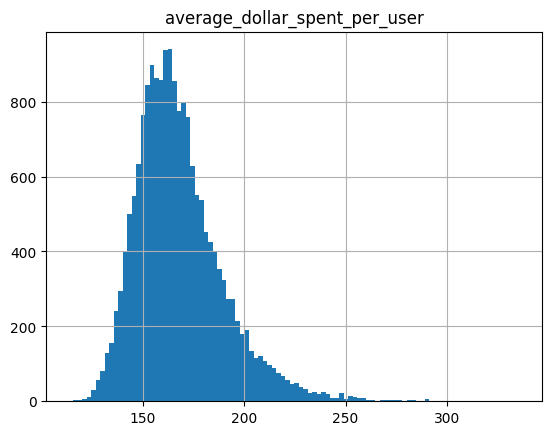

In [6]:
# Convert the PySpark DataFrame to a Pandas DataFrame
average_dollar_spent_pd = average_dollar_spent_per_user.toPandas()

# plot the distribution of the average dollar spent per user
average_dollar_spent_pd.hist(column='average_dollar_spent_per_user', bins=100)